## Encoding Rewards

#### Encoding Rewards

- We've now discussed the importance of encoding the observations.
- We may also have some choice on the action space, though here (and often) it is relatively clear/fixed.
- But what about the rewards? 

#### Current set-up

- Currently, we get a reward of +1 for reaching the goal. 
- This is part of what makes RL so hard (and impressive):
  - We want to learn about actions even though we don't know right away whether the action was "good". 
  - Contrast this with supervised learning, where every prediction we make on the training data can immediately be compared with the known target value.


In [1]:
# TODO: perhaps this next slide can be moved to Module 1, since it's very general?

#### Agents can't just be greedy

- Can agents simply learn to go for the best immediate reward?
- No. For example, in a video recommendation system, showing the user another funny cat video might make them click (high immediate reward) but result in long-term loss of interest in the service (low long-term reward).
- Our Frozen Lake is another example of the problem here: sometimes there is no immediate reward at all to learn from.

In [2]:
# TODO: perhaps this next section on "Learned action probabilities" could be moved much earlier, even as early as Module 1

#### Learned action probabilities

- RLlib lets us look inside the model at the probability of each action given an observation (i.e., the learned policy).
- Let's load the trained model with our encoded observations:

In [34]:
from envs import RandomLakeObs
from ray.rllib.agents.ppo import PPOTrainer

trainer_RandomLakeObs = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, "horizon" : 100}, 
                       env=RandomLakeObs)

In [35]:
trainer_RandomLakeObs.restore("models/RandomLakeObs/checkpoint-8")

2022-06-17 10:22:05,406	INFO trainable.py:495 -- Restored on 127.0.0.1 from checkpoint: models/RandomLakeObs/checkpoint-8
2022-06-17 10:22:05,415	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': 32000, '_time_total': 26.671697854995728, '_episodes_total': 3536}


#### Learned action probabilities

The exact RLlib code is hidden inside `utils` for now, but we're mainly interested in the results:

In [5]:
from utils import query_policy
query_policy(trainer_RandomLakeObs, RandomLakeObs(), [0,0,0,0])

array([0.04938994, 0.5083452 , 0.4160391 , 0.02622576], dtype=float32)

- Recall the (left, down, right, up) ordering.
- When the observation is `[0 0 0 0]` (no holes or edges in sight), the agent prefers to go down and right.

What if there's a hole below you? We can feed in a different observation to the policy:

In [6]:
query_policy(trainer_RandomLakeObs, RandomLakeObs(), [0,1,0,0])

array([0.03247996, 0.02870463, 0.9153594 , 0.02345585], dtype=float32)

- Now the agent is very unlikely to go down, and very likely to go right!
- Again, all this was learned from trial and error, with a reward earned only when the goal was reached.

#### Random Lake rewards

- In the Random Lake example, can't be make life easier for the agent by giving immediate rewards?

This is the current reward code:

In [7]:
def reward(self):
    return int(self.player == self.goal)

- The agent has to learn, through trial and error over _entire episodes_, that moving down and right is generally a good thing. 

#### Redefining rewards

- Let's instead try giving a reward _at every step, that is higher as the agent gets closer to the goal_. 

In [8]:
from envs import RandomLakeObs

class RandomLakeObsRew(RandomLakeObs):
    def reward(self):
        return 6-(abs(self.player[0]-self.goal[0]) + abs(self.player[1]-self.goal[1]))

- The above method uses the [Manhattan Distance](https://en.wikipedia.org/wiki/Taxicab_geometry) between the player and the goal as the reward. 
- When the agent reaches the goal, the maximum reward of 6 is achieved.
- When the agent is furthest from the goal, the minimum reward of 0 is given.

#### Redefining rewards

In [9]:
env = RandomLakeObsRew()
env.reset()
env.render()
env.reward()

P...
....
O.O.
...G


0

⬆️ the reward is 0

⬇️ the reward is 1 because we moved closer to the goal

In [10]:
obs, rew, done, _ = env.step(1)
env.render()
rew

....
P...
O.O.
...G


1

#### Redefining rewards

In [11]:
obs, rew, done, _ = env.step(2)
obs, rew, done, _ = env.step(2)
obs, rew, done, _ = env.step(2)
obs, rew, done, _ = env.step(1)
env.render()
rew

....
....
O.OP
...G


5

Now, the reward is 5. Next, it will be 6.

In [12]:
obs, rew, done, _ = env.step(1)
env.render()
rew

....
....
O.O.
...P


6

#### Comparing rewards

- So, we have two possible reward functions. Which one works better? 
- Recall that last time, after training for 8 iterations, we were able to reach the goal around 70% of the time:

In [13]:
trainer_RandomLakeObs.evaluate()['evaluation']['episode_reward_mean']

0.7023809523809523

#### Comparing rewards

Let's train with the new reward function!

In [14]:
trainer_RandomLakeObsRew = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, "horizon" : 100}, 
                                      env=RandomLakeObsRew)

In [15]:
for i in range(8):
    trainer_RandomLakeObsRew.train()

In [16]:
trainer_RandomLakeObsRew.evaluate()['evaluation']['episode_reward_mean']

133.5897435897436

Wait a minute, what's going on here??

#### Comparing rewards?

- We tried to improve our RL system by shaping the reward function.
- This (presumably) affected training, but it also affected our evaluation.
- In supervised learning, this is like changed the scoring metric from squared error to absolute error.
- If the old system got a mean squared error of 20,000 and the new system got a mean absolute error of 40, which is better?
- We're comparing apples and oranges here!
- We want to compare both models on the same metric, for example the original metric. 
- Here, we want to see how frequently the agent reaches the goal.

#### Comparing rewards?

- The code here is a bit more advanced.
- It is included for completeness, but we won't go into detail.

In [17]:
from ray.rllib.agents.callbacks import DefaultCallbacks

class MyCallbacks(DefaultCallbacks):
    def on_episode_end(self, *, worker, base_env, policies, episode, env_index, **kwargs):
        info = episode.last_info_for()
        episode.custom_metrics["goal_reached"] = info["player"] == info["goal"]

In [18]:
trainer_RandomLakeObsRew = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, 
                                      "callbacks" : MyCallbacks, "horizon" : 100,
                                      "evaluation_config" : {"callbacks" : MyCallbacks}},
                                      env=RandomLakeObsRew)

The trainer above uses our new reward scheme but also reports/measures the rate of reaching the goal.

#### Comparing rewards?

Let's try it out!

In [19]:
for i in range(8):
    trainer_RandomLakeObsRew.train()

In [20]:
# HIDDEN
trainer_RandomLakeObsRew.evaluate()["evaluation"]["episode_reward_mean"]

133.5897435897436

In [21]:
trainer_RandomLakeObsRew.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.023809523809523808

- Hmm, these results are terrible!
- We used to get a 70%+ win rate, and now we're close to zero.
- What happened? 🤔

#### What is the agent really optimizing?

- The agent is really optimizing _discounted total reward_.
- _Total_: it values all the rewards it collects, not just the final reward.
- _Discounted_: it values earlier rewards more than later ones.
- Our agent is successfully maximizing discounted total reward, but this isn't corresponding to reaching the goal.
- But why? The goal gives a higher reward.

#### Exploration vs. exploitation

- A fundamental concept in RL is _exploration vs. exploitation_
- When the agent is learning the policy, it can choose to either:

1. Do things that it knows are pretty good ("exploit")
2. Try something totally new and crazy, just in case ("explore")

In [22]:
# TODO 
# diagram for this?

#### Exploration vs. exploitation

- With the old reward structure, the agent gets a reward of 0 unless it reaches the goal.
  - So, it keeps trying to find something better.
- With the new reward structure, the agent is getting lots of reward just for walking around.
  - It isn't very motivated to explore the environment.
- In fact, because it is maximizing discounted **total** reward, finding the goal is a bad thing!
  - This causes the episode to end, limiting the total reward of the agent.
  - The agent actually learns to _avoid_ the goal, especially early on in the episode.

#### Designing a better reward structure

- Instead, let's try penalizing the agent when it walks into a hole or off the edge.
- It will be easier to implement this directly in `step`:

In [23]:
class RandomLakeObsRew2(RandomLakeObs):
    def step(self, action):
        # (not shown) existing code gets new_loc, where the player is trying to go
        
        reward = 0
        
        if self.is_valid_loc(new_loc):
            self.player = new_loc
        else:
            reward -= 0.1 # small penalty
            
        if self.holes[self.player]:
            reward -= 0.1 # small penalty
            
        if self.player == self.goal:
            reward += 1
        
        # Return observation/reward/done
        return self.observation(), reward, self.done(), {"player" : self.player, "goal" : self.goal}

In [24]:
# HIDDEN
from envs import RandomLakeObsRew2

#### Testing it out, again

In [37]:
# HIDDEN
# do this again so that you can measure the custom metric instead of the reward
# they will give the same value but this is better for consistency
trainer_RandomLakeObs = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, 
                                      "callbacks" : MyCallbacks, "horizon" : 100,
                                      "evaluation_config" : {"callbacks" : MyCallbacks}},
                                      env=RandomLakeObs)

for i in range(8):
    trainer_RandomLakeObs.train()

In [30]:
trainer_RandomLakeObsRew2 = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, 
                                      "callbacks" : MyCallbacks, "horizon" : 100,
                                      "evaluation_config" : {"callbacks" : MyCallbacks}},
                                      env=RandomLakeObsRew2)

In [31]:
for i in range(8):
    trainer_RandomLakeObsRew2.train()

In [38]:
trainer_RandomLakeObs.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.7512953367875648

In [39]:
trainer_RandomLakeObsRew2.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.7279151943462897

It looks like, this time, the two methods perform about the same.

#### Episode length

- In addition to the success rate, we can compute other statistics of the agent's behavior.
- One interesting measure is episode length.
- RLlib records this by default, so we can easily access it:

In [32]:
trainer_RandomLakeObs.evaluate()["evaluation"]["episode_len_mean"]

12.628930817610064

In [33]:
trainer_RandomLakeObsRew2.evaluate()["evaluation"]["episode_len_mean"]

7.270370370370371

- Although the two agents have the same success rate, the new one tends toward shorter episodes.
- This is quite interesting because the agent cannot "see" the difference between holes and edges.
- We could explore this further by adding more custom metrics, e.g. number of bumps into the edge.

In [5]:
RandomLakeObs_results = []

for i in range(8):
    RandomLakeObs_results.append(trainer_RandomLakeObs.train())

In [6]:
RandomLakeObsRew2_results = []

for i in range(8):
    RandomLakeObsRew2_results.append(trainer_RandomLakeObsRew2.train())

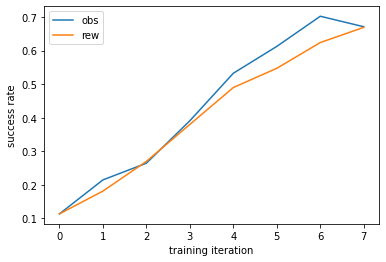

In [7]:
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in RandomLakeObs_results], label="obs")
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in RandomLakeObsRew2_results], label="rew")
plt.xlabel("training iteration")
plt.ylabel("success rate")
plt.legend();

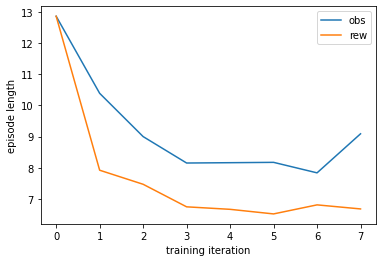

In [8]:
plt.plot([x["episode_len_mean"] for x in RandomLakeObs_results], label="obs")
plt.plot([x["episode_len_mean"] for x in RandomLakeObsRew2_results], label="rew")
plt.xlabel("training iteration")
plt.ylabel("episode length")
plt.legend();

In [3]:
for i in range(8):
    trainer_RandomLakeObsRew2.train()

In [4]:
trainer_RandomLakeObsRew2.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.7237354085603113

In [33]:
# HIDDEN
trainer_RandomLakeObsRew2.evaluate()["evaluation"]["episode_reward_mean"]

0.09602977667493798

In [ ]:
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in RandomLakeObs_results], label="obs")
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in RandomLakeObsRew2_results], label="rew")
plt.xlabel("training iteration")
plt.ylabel("success rate")
plt.legend();

In [35]:
from envs import RandomLakeObsRew2, RandomLakeObs
import matplotlib.pyplot as plt

In [4]:
from ray.rllib.agents.callbacks import DefaultCallbacks

class MyCallbacks(DefaultCallbacks):
    def on_episode_end(self, *, worker, base_env, policies, episode, env_index, **kwargs):
        info = episode.last_info_for()
        episode.custom_metrics["goal_reached"] = info["player"] == info["goal"]

In [5]:
from ray.rllib.agents.ppo import PPOTrainer


trainer_RandomLakeObs = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0,
                                      "callbacks" : MyCallbacks, "horizon" : 100,
                                      "evaluation_config" : {"callbacks" : MyCallbacks}},
                                    env=RandomLakeObs)

In [6]:
trainer_RandomLakeObsRew2 = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, 
                                      "callbacks" : MyCallbacks, "horizon" : 100,
                                      "evaluation_config" : {"callbacks" : MyCallbacks}},
                                      env=RandomLakeObsRew2)

In [7]:
# for i in range(8):
#     trainer_RandomLakeObsRew.train()

In [8]:
outs_RandomLakeObs = []
for i in range(8):
    outs_RandomLakeObs.append(trainer_RandomLakeObs.train())

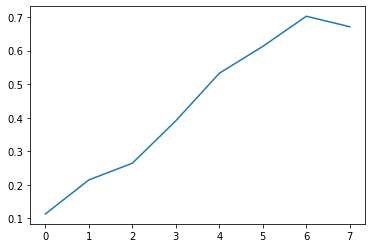

In [9]:
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in outs_RandomLakeObs]);

In [10]:
trainer_RandomLakeObs.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.7512953367875648

In [11]:
outs_RandomLakeObsRew2 = []
for i in range(8):
    outs_RandomLakeObsRew2.append(trainer_RandomLakeObsRew2.train())

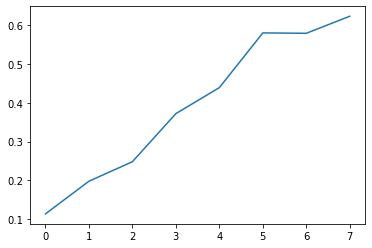

In [12]:
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in outs_RandomLakeObsRew2]);

In [13]:
trainer_RandomLakeObsRew2.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.6666666666666666

In [ ]:
trainer_RandomLakeObs.config["model"]["vf_share_layers"]

In [ ]:
env = RandomLakeObsTest()
obs = env.reset()

In [ ]:
action = trainer_RandomLakeObsTest.compute_single_action(input_dict={"obs": obs})#, explore=False)
res = env.step(action)
obs = res[0]
env.render()

print("\naction:", action)
print("reward:", res[1])
print("done:", res[2])
print("obs:", obs)

#### callback thing

#### training curves

#### disadvantages - loss of generality

- now only works if goal is at bottom-right
give a few real-world examples here -> important

## Supervised learning analogy: reward shaping

Earlier, we made an analogy between encoding observations in RL and feature preprocessing in supervised learning. What aspect of supervised learning is the best analogy to reward shaping in RL?

- [ ] Feature engineering 
- [ ] Model selection | Not quite. But, as we'll see, there is a place for model selection in RL as well!
- [ ] Hyperparameter tuning | Not quite. But, as we'll see, there is a place for hyperparameter tuning in RL as well!
- [x] Selecting a loss function | Changing the loss function changes the "best" model, just like changing the rewards changes the "best" policy.

## Sign of rewards NAME TODO

In our Random Lake environment, we tried giving a small negative reward for every step. How does this change affect the amount of time the agent might spend until it reaches the goal?

- [x] The agent will try to reach the goal in as few steps as possible.
- [ ] The agent will try to reach the goal in as many steps as possible.
- [ ] This change to the reward will not affect the agent's "motivation" to reach t 

TODO


multiple choice idea:
forget